In [77]:
#import Pkg
#Pkg.add("Plots")

In [78]:
using LinearAlgebra
using Plots

In [79]:
function f1(x::Float64, α::Float64, β::Float64)
    return -2*α + β*(x^2-x)
end

function f1_solution(x::Float64)
    return x*(x-1)
end

function f2(x::Float64, α::Float64, β::Float64)
    return (α*π^2 + β)*sin(π*x)
end

function f2_solution(x::Float64)
    return sin(π*x)
end

f2_solution (generic function with 1 method)

In [80]:
function get_point(index::Int64, m::Int64)
    return convert(Float64, index/(m+1))     
end

function solution_on_points(α::Float64, β::Float64, m::Int64, f)
    exact_solution = zeros(m)
    for i in 1:m
        point = get_point(i, m)
        exact_solution[i] = f(point)::Float64
    end

    return exact_solution
end

solution_on_points (generic function with 1 method)

In [81]:
function solution_on_points(α::Float64, β::Float64, m::Int64, f)
    exact_solution = zeros(m)
    for i in 1:m
        point = get_point(i, m)
        exact_solution[i] = f(point)::Float64
    end

    return exact_solution
end

function solve_equation(α::Float64, β::Float64, m::Int64, f)

    h = 1/(m+1) 

    A = zeros((m, m))
    
    for i in 2:m-1
        A[i, i-1] = -α
        A[i, i  ] = β*h^2 + 2*α
        A[i, i+1] = -α
    end

    # linhas de contorno
    A[1, 1] = β*h^2 + 2*α
    A[1, 2] = -α

    A[m, m-1] = -α
    A[m, m] = β*h^2 + 2*α


    b = zeros(m)
    for i in 2:m-1
        
        point = get_point(i, m)
        b[i] = h^2*f(point, α, β)::Float64
    end

    #linhas de contorno
    b[1] = h^2*f(get_point(1, m), α, β)::Float64
    b[m] = h^2*f(get_point(m, m), α, β)::Float64

    num_solution = A\b
    
    return num_solution
end

solve_equation (generic function with 1 method)

Caso 1

In [82]:
α = 1.0
β = 1.0
m = 4

num_sol = solve_equation(α, β, m, f1)
exact_sol = solution_on_points(α, β, m, f1_solution)

display("Solução numérica: ")
display(num_sol)

display("Solução exata: ")
display(exact_sol)

"Solução numérica: "

4-element Vector{Float64}:
 -0.16
 -0.24000000000000002
 -0.23999999999999996
 -0.15999999999999998

"Solução exata: "

4-element Vector{Float64}:
 -0.16000000000000003
 -0.24
 -0.24
 -0.15999999999999998

Caso 1 - Plot Soluções

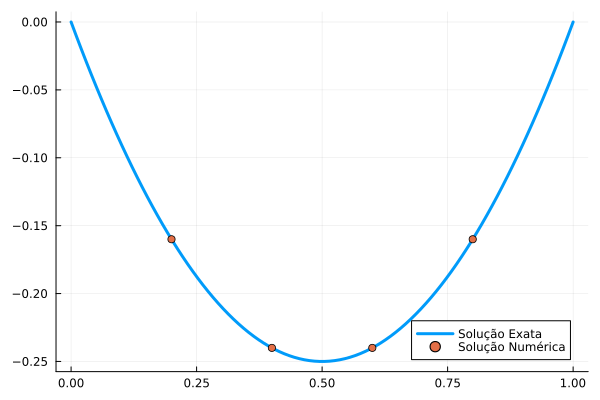

In [83]:
points = get_point.(1:m, Iterators.repeated(m, m))
plot(f1_solution, range(0, 1, 100), lw=3, label="Solução Exata")
plot!(points, num_sol, lw=3, seriestype=:scatter, label="Solução Numérica")

Caso 1 - Plot Erro

9×2 Matrix{Any}:
 0.25         2.77556e-17
 0.125        5.55112e-17
 0.0625       1.66533e-16
 0.03125      2.498e-16
 0.015625     1.22125e-15
 0.0078125    1.08247e-15
 0.00390625   7.35523e-15
 0.00195312   9.79772e-15
 0.000976562  1.80134e-14

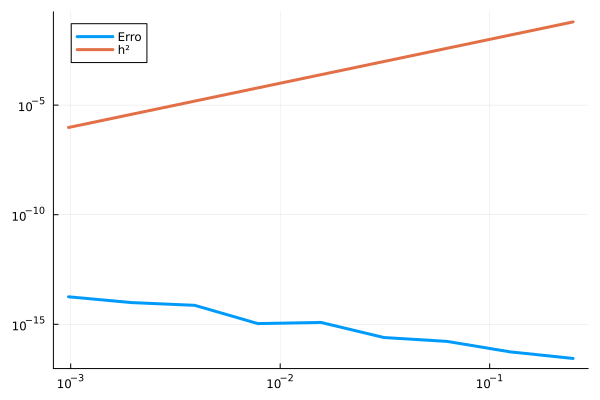

In [84]:
erros = []
n_testes = 10
m_list = (2 .^(2:n_testes)) .- 1
h_list = 1 ./ (m_list .+ 1)

for m in m_list
    points = get_point.(1:m, Iterators.repeated(m, m))

    uh = solve_equation(α, β, m, f1)
    u = f1_solution.(points)    

    erro = norm(u - uh, Inf)
    push!(erros, erro)
end

display([h_list erros])


plot(h_list, erros, lw=3, label="Erro", xscale = :log10, yscale = :log10)
plot!(h_list, h_list.^2, lw=3, label="h²", xscale = :log10, yscale = :log10, legend=:topleft)

Caso 2

In [85]:
α = 1.0
β = 1.0
m = 7

num_sol = solve_equation(α, β, m, f2)
exact_sol = solution_on_points(α, β, m, f2_solution)

display("Solução numérica: ")
display(num_sol)

display("Solução exata: ")
display(exact_sol)

"Solução numérica: "

7-element Vector{Float64}:
 0.3871781595774367
 0.7154119541379652
 0.9347307639065021
 1.0117452882257492
 0.9347307639065022
 0.7154119541379653
 0.38717815957743684

"Solução exata: "

7-element Vector{Float64}:
 0.3826834323650898
 0.7071067811865475
 0.9238795325112867
 1.0
 0.9238795325112867
 0.7071067811865476
 0.3826834323650899

Caso 2 - Plot

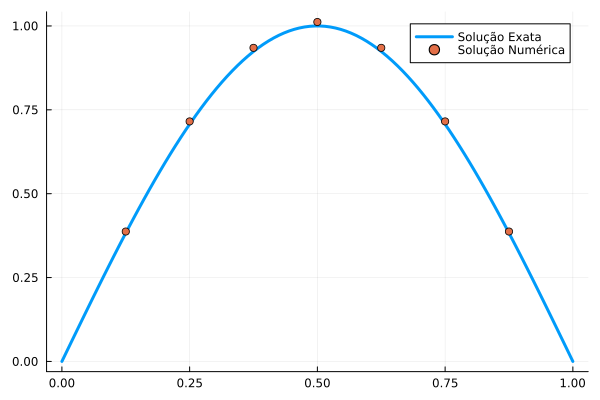

In [86]:
points = get_point.(1:m, Iterators.repeated(m, m))
plot(f2_solution, range(0, 1, 100), lw=3, label="Solução Exata")
plot!(points, num_sol, lw=3, seriestype=:scatter, label="Solução Numérica")

Caso 2 - Plot Erro

9×2 Matrix{Any}:
 0.25         0.0479168
 0.125        0.0117453
 0.0625       0.00292196
 0.03125      0.000729595
 0.015625     0.000182343
 0.0078125    4.55822e-5
 0.00390625   1.13953e-5
 0.00195312   2.84882e-6
 0.000976562  7.12205e-7

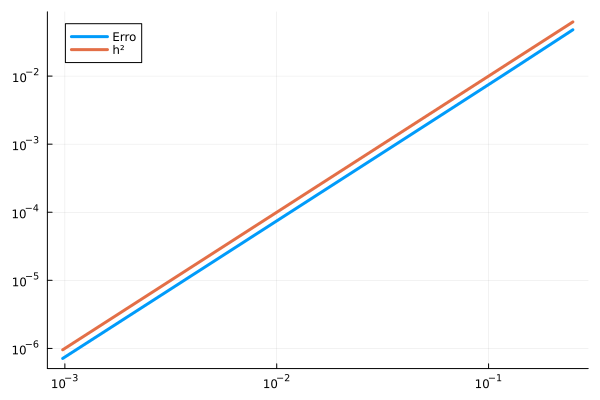

In [87]:
erros = []
n_testes = 10
m_list = (2 .^(2:n_testes)) .- 1
h_list = 1 ./ (m_list .+ 1)

for m in m_list
    points = get_point.(1:m, Iterators.repeated(m, m))

    uh = solve_equation(α, β, m, f2)
    u = f2_solution.(points)    

    erro = norm(u - uh, Inf)
    push!(erros, erro)
end

display([h_list erros])


plot(h_list, erros, lw=3, label="Erro", xscale = :log10, yscale = :log10)
plot!(h_list, h_list.^2, lw=3, label="h²", xscale = :log10, yscale = :log10, legend=:topleft)

In [105]:
function monta_K(α::Float64, β::Float64, m::Int64)
    h = 1/(m+1) 

    A = zeros((m, m))
    
    for i in 2:m-1
        A[i, i-1] = -α/h + (β*h)/6
        A[i, i  ] = (2*α/h) + (2*β*h)/3
        A[i, i+1] = -α/h + (β*h)/6
    end

    # linhas de contorno
    A[1, 1] = (2*α/h) + (2*β*h)/3
    A[1, 2] = -α/h + (β*h)/6

    A[m, m-1] = -α/h + (β*h)/6
    A[m, m] = (2*α/h) + (2*β*h)/3

    return A
    
end

function solve_via_galerkin_1(α::Float64, β::Float64, m::Int64, K::Matrix{Float64}, f)

    h = 1/(m+1) 

    b = zeros(m)
    for i in 1:m
        b[i] = 8*h

    end

    num_solution = K\b

    prepend!(num_solution, 0)
    append!(num_solution, 0)
    
    return num_solution
end

function solve_via_galerkin_2(α::Float64, β::Float64, m::Int64, K::Matrix{Float64}, f)

    h = 1/(m+1) 

    b = zeros(m)
    points = get_point.(1:m, m)
    
    for i in 1:m
        b[i] = h*points[i]
    end

    num_solution = K\b

    prepend!(num_solution, 0)
    append!(num_solution, 0)
    
    return num_solution
end

solve_via_galerkin_2 (generic function with 1 method)

In [89]:
function f3(x::Float64, α::Float64, β::Float64)
    return 8.0::Float64
end

function f3_solution(x::Float64)
    return -4*x*(x-1)::Float64
end

function f4(x::Float64, α::Float64, β::Float64)
    return x::Float64
end

function f4_solution(x::Float64)
    return x+(exp(-x) - exp(x))/(exp(1) - exp(-1)) ::Float64
end

f4_solution (generic function with 1 method)

Caso 3 - plot

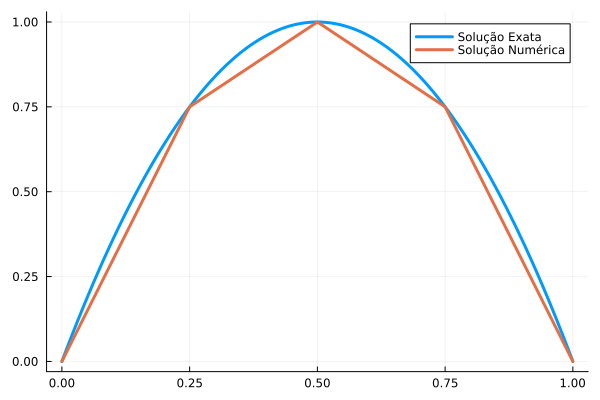

In [103]:
m = 3
diff_sol = solve_equation(1.0, 0.0, m, f3)

K = monta_K(1.0, 0.0, m)
galerkin_sol = solve_via_galerkin_1(1.0, 0.0, m, K, f3)

h = 1/(m+1)
points = get_point.(0:m+1, m)
erro = maximum(abs.(f3_solution.(points) - galerkin_sol))

points = get_point.(0:m+1, m)
plot(f3_solution, range(0, 1, 100), lw=3, label="Solução Exata")
plot!(points, galerkin_sol, lw=3, label="Solução Numérica")

9×2 Matrix{Any}:
 0.25         1.11022e-16
 0.125        1.11022e-16
 0.0625       1.11022e-16
 0.03125      3.10862e-15
 0.015625     9.54792e-15
 0.0078125    9.54792e-15
 0.00390625   3.55271e-14
 0.00195312   7.9492e-14
 0.000976562  3.6493e-13

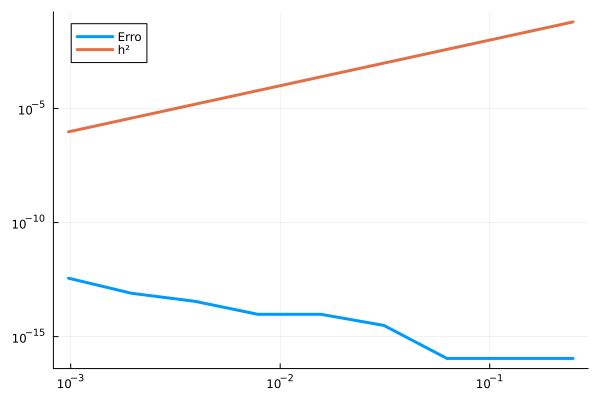

In [102]:
erros = []
n_testes = 10
m_list = (2 .^(2:n_testes)) .- 1
h_list = 1 ./ (m_list .+ 1)

for m in m_list
    points = get_point.(0:m+1, m)

    K = monta_K(1.0, 0.0, m)
    uh = solve_via_galerkin_1(1.0, 0.0, m, K, f3)
    u = f3_solution.(points)    

    erro = norm(u - uh, Inf)
    push!(erros, erro)
end

#display([h_list erros])


plot(h_list, erros, lw=3, label="Erro", xscale = :log10, yscale = :log10)
plot!(h_list, h_list.^2, lw=3, label="h²", xscale = :log10, yscale = :log10, legend=:topleft)

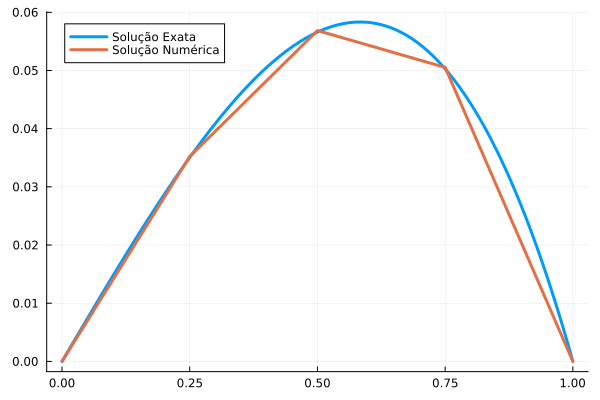

In [106]:
m = 3
diff_sol = solve_equation(1.0, 1.0, m, f4)

K = monta_K(1.0, 1.0, m)
galerkin_sol = solve_via_galerkin_2(1.0, 1.0, m, K, f4)

h = 1/(m+1)
points = get_point.(0:m+1, m)
erro = maximum(abs.(f4_solution.(points) - galerkin_sol))

points = get_point.(0:m+1, m)
plot(f4_solution, range(0, 1, 100), lw=3, label="Solução Exata")
plot!(points, galerkin_sol, lw=3, label="Solução Numérica")

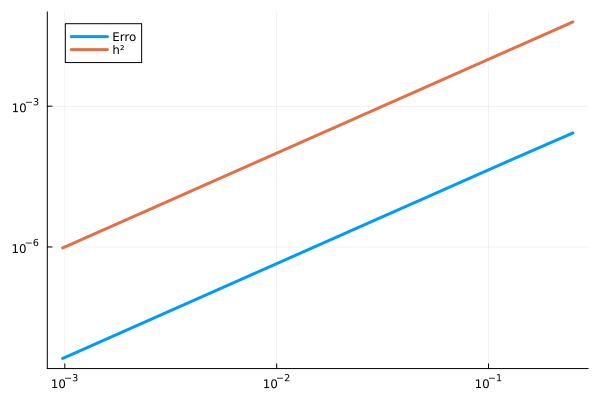

In [108]:
erros = []
n_testes = 10
m_list = (2 .^(2:n_testes)) .- 1
h_list = 1 ./ (m_list .+ 1)

for m in m_list
    points = get_point.(0:m+1, m)

    K = monta_K(1.0, 1.0, m)
    uh = solve_via_galerkin_2(1.0, 1.0, m, K, f4)
    u = f4_solution.(points)    

    erro = norm(u - uh, Inf)
    push!(erros, erro)
end

#display([h_list erros])


plot(h_list, erros, lw=3, label="Erro", xscale = :log10, yscale = :log10)
plot!(h_list, h_list.^2, lw=3, label="h²", xscale = :log10, yscale = :log10, legend=:topleft)